# Определение перспективного тарифа для телеком компании

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [2]:
#импортировали библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats as st

In [3]:
#прочитали данные из файла
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [4]:
pd.set_option('display.max_columns', None)
calls.head() 

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [5]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [6]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [7]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


In [8]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [9]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [10]:
tariffs.head()

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [11]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mg_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [12]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


### Шаг 2. Подготовьте данные

Приведите данные к нужным типам.

In [14]:
tariffs['tariff_name'] = tariffs['tariff_name'].astype('str')

Найдите и исправьте ошибки в данных.

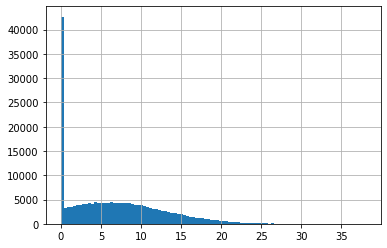

In [15]:
#длительность звонка в минутах на графике
calls['duration'].hist(bins=100)

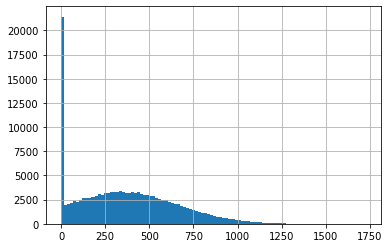

In [16]:
#объём потраченного за сессию интернет-трафика (в мегабайтах) на графике
internet['mb_used'].hist(bins=100)

Звонки длительностью 0 минут не оплачиваются, поэтому удалим их, аналогично, удалим нулевые значения объёма потраченного за сессию интернет-трафика в мегабайтах.

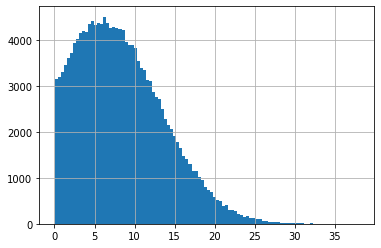

In [17]:
calls = calls.query('duration > 0')
calls['duration'].hist(bins=100)

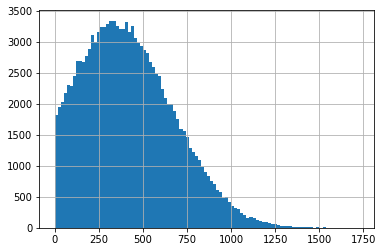

In [18]:
internet = internet.query('mb_used > 0')
internet['mb_used'].hist(bins=100)

Теперь длительность звонка в минутах и объём потраченного за сессию интернет-трафика нормально распределены.

Посчитайте для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [19]:
#добавим столбец месяца в таблицы calls, masseges, internet
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d %H:%M:%S')
calls['month'] = pd.DatetimeIndex(calls['call_date']).month

messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d %H:%M:%S')
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d %H:%M:%S')
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

In [20]:
#сгруппируем звонки по месяцам и user_id
data_pivot_calls = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['sum', 'count'])
data_pivot_calls.columns = ['calls_sum', 'calls_count']

In [21]:
#округлим вверх значения минут и приведем к целому типу
data_pivot_calls['calls_sum']=np.ceil(data_pivot_calls['calls_sum']).astype(int)

In [22]:
data_pivot_calls.head(15)

calls_sum  calls_count
user_id month                        
1000    5            151           17
        6            159           28
        7            319           41
        8            390           42
        9            441           46
        10           329           44
        11           320           37
        12           313           38
1001    11           409           45
        12           392           47
1002    6            111           14
        7            205           21
        8            270           37
        9            196           25
        10           200           24

In [23]:
#сгруппируем отправленные сообщения по месяцам и user_id
data_pivot_masseges = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc=['count'])
data_pivot_masseges.columns = ['messages_count']

In [24]:
data_pivot_masseges.head()

messages_count
user_id month                
1000    5                  22
        6                  60
        7                  75
        8                  81
        9                  57

In [25]:
#сгруппируем объем израсходованного интернет-трафика по месяцам и user_id
data_pivot_internet = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc=['sum'])
data_pivot_internet.columns = ['mb_used_sum']

In [26]:
#округлим вверх значения мегабайт и приведем к целому типу
data_pivot_internet['mb_used_sum']=np.ceil(data_pivot_internet['mb_used_sum']).astype(int)

In [27]:
data_pivot_internet.head()

mb_used_sum
user_id month             
1000    5             2254
        6            23234
        7            14004
        8            14056
        9            14569

In [28]:
#обединим данные за месяц в одну таблицу
users_month_pivot = data_pivot_internet.join([data_pivot_masseges, data_pivot_calls])

In [29]:
users_month_pivot.head()

mb_used_sum  messages_count  calls_sum  calls_count
user_id month                                                     
1000    5           2254.0            22.0      151.0         17.0
        6          23234.0            60.0      159.0         28.0
        7          14004.0            75.0      319.0         41.0
        8          14056.0            81.0      390.0         42.0
        9          14569.0            57.0      441.0         46.0

In [30]:
users_month_pivot.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3201 entries, (1000, 5) to (1499, 12)
Data columns (total 4 columns):
mb_used_sum       3201 non-null float64
messages_count    2704 non-null float64
calls_sum         3155 non-null float64
calls_count       3155 non-null float64
dtypes: float64(4)
memory usage: 293.9 KB


In [31]:
#выделим в отдельные столбцы id и месяц
users_month_pivot['id'] = users_month_pivot.index.get_level_values('user_id')
users_month_pivot['month'] = users_month_pivot.index.get_level_values('month')

In [32]:
#переиндексируем и удалим старые индексы
users_month_pivot = users_month_pivot.reset_index(drop = True)
#заменим пропуски в messages и calls на 0, так как абоненты их не использовали
users_month_pivot = users_month_pivot.fillna(0)

In [33]:
#переименуем столбцы в таблице users
users.set_axis(['id', 'age', 'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'tariff_name'], 
               axis = 'columns', 
               inplace = True)

In [34]:
#объединим таблицы users_month_pivot,users и tariffs
users_month_pivot = users_month_pivot.merge(users, on='id')
users_month_pivot = users_month_pivot.merge(tariffs, on='tariff_name')

In [35]:
users_month_pivot.head()

,mb_used_sum,messages_count,calls_sum,calls_count,id,month,age,churn_date,city,first_name,last_name,reg_date,tariff_name,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,2254.0,22.0,151.0,17.0,1000,5,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,23234.0,60.0,159.0,28.0,1000,6,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,14004.0,75.0,319.0,41.0,1000,7,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,14056.0,81.0,390.0,42.0,1000,8,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,14569.0,57.0,441.0,46.0,1000,9,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


In [36]:
users_month_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3201 entries, 0 to 3200
Data columns (total 20 columns):
mb_used_sum              3201 non-null float64
messages_count           3201 non-null float64
calls_sum                3201 non-null float64
calls_count              3201 non-null float64
id                       3201 non-null int64
month                    3201 non-null int64
age                      3201 non-null int64
churn_date               186 non-null object
city                     3201 non-null object
first_name               3201 non-null object
last_name                3201 non-null object
reg_date                 3201 non-null object
tariff_name              3201 non-null object
messages_included        3201 non-null int64
mg_per_month_included    3201 non-null int64
minutes_included         3201 non-null int64
rub_monthly_fee          3201 non-null int64
rub_per_gb               3201 non-null int64
rub_per_message          3201 non-null int64
rub_per_minute           

In [37]:
#Посчитайте для каждого пользователя помесячную выручку с каждого пользователя 
#(вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; 
#остаток умножьте на значение из тарифного плана; 
#прибавьте абонентскую плату, соответствующую тарифному плану).
def revenue(data):
    minutes = 0
    message = 0
    gb = 0
    
    # количество минут разговора в месяц, включённых в абонентскую плату
    minutes_included = data['minutes_included']
    if data['calls_sum'] > minutes_included:
        #округлим до ближайшего большего разницу суммарного количества звонков
        #и минут включенных в абонентскую плату
        minutes = math.ceil(data['calls_sum'] - minutes_included)
        
    #сделаем тоже для сообщений и мегабайт
    messages_included = data['messages_included']
    if data['messages_count'] > messages_included:
        message = math.ceil(data['messages_count'] - messages_included)
        
    mg_per_month_included = data['mg_per_month_included']
    if data['mb_used_sum'] > mg_per_month_included:
        #переведем в гигабайты
        gb = math.ceil((data['mb_used_sum'] - mg_per_month_included) / 1024)
        
    summa = (data['rub_monthly_fee'] + minutes * data['rub_per_minute'] + 
             message * data['rub_per_message'] + 
             gb * data['rub_per_gb'])
    
    return summa
#добавим новый столбец с выручкой
users_month_pivot['revenue'] = users_month_pivot.apply(revenue, axis=1)

In [38]:
users_month_pivot.head()

,mb_used_sum,messages_count,calls_sum,calls_count,id,month,age,churn_date,city,first_name,last_name,reg_date,tariff_name,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
0,2254.0,22.0,151.0,17.0,1000,5,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
1,23234.0,60.0,159.0,28.0,1000,6,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
2,14004.0,75.0,319.0,41.0,1000,7,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
3,14056.0,81.0,390.0,42.0,1000,8,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
4,14569.0,57.0,441.0,46.0,1000,9,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950


### Шаг 3. Проанализируйте данные

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

In [39]:
#поделим выборку на тарифы ultra и smart
users_month_pivot_ultra = users_month_pivot.query('tariff_name == "ultra"')
users_month_pivot_smart = users_month_pivot.query('tariff_name == "smart"')

#### Smart

{'whiskers': [<matplotlib.lines.Line2D at 0x7fbb7c4ae4d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fbb7c4aef10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fbb7c426e90>],
 'medians': [<matplotlib.lines.Line2D at 0x7fbb7c3ed990>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fbb7c3ede90>],
 'means': []}

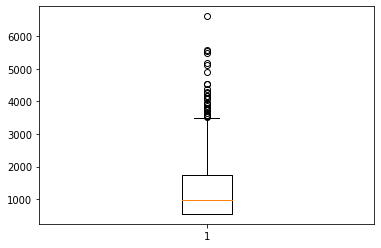

In [40]:
#рассмотрим тариф smart
plt.boxplot(users_month_pivot_smart['revenue'])

В среднем за месяц люди платят 1000 рублей. Все что больше 3600 рублей можно считать выбросами.

In [41]:
users_month_pivot_smart = users_month_pivot_smart.query('revenue <= 3600')

In [42]:
#Сколько минут разговора, сколько сообщений и какой объём интернет-трафика 
#требуется пользователям каждого тарифа в месяц? 
#Посчитайте среднее количество, дисперсию и стандартное отклонение. 
#Постройте гистограммы. Опишите распределения.

In [43]:
#минуты
print('среднее',users_month_pivot_smart['calls_sum'].mean())
print('медиана',users_month_pivot_smart['calls_sum'].median())
print('дисперсия',np.var(users_month_pivot_smart['calls_sum']))
print('стандартное отклонение',np.sqrt(np.var(users_month_pivot_smart['calls_sum'])))

среднее 391.86954545454546
медиана 396.0
дисперсия 31008.574345247936
стандартное отклонение 176.09251643737713


In [44]:
 #users_month_pivot_smart.query('calls_sum > 500').count()

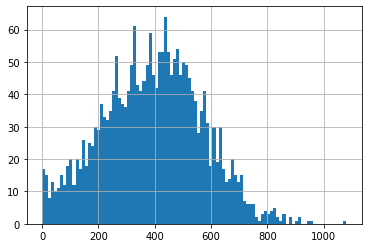

In [45]:
#гистограмма
users_month_pivot_smart['calls_sum'].hist(bins=100)

Медиана больше среднего, значит датасет скошен влево.

In [46]:
#сообщения
print('среднее',users_month_pivot_smart['messages_count'].mean())
print('медиана',users_month_pivot_smart['messages_count'].median())
print('дисперсия',np.var(users_month_pivot_smart['messages_count']))
print('стандартное отклонение',np.sqrt(np.var(users_month_pivot_smart['messages_count'])))

среднее 33.30863636363637
медиана 28.0
дисперсия 785.0742890495868
стандартное отклонение 28.019177165819606


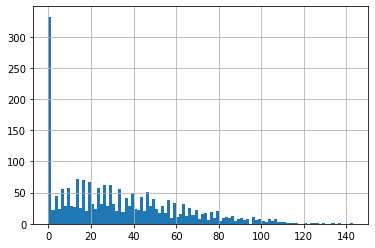

In [47]:
#гистограмма
users_month_pivot_smart['messages_count'].hist(bins=100)

Медиана меньше среднего, значит датасет скошен вправо.

In [48]:
#объём интернет-трафика 
print('среднее',users_month_pivot_smart['mb_used_sum'].mean())
print('медиана',users_month_pivot_smart['mb_used_sum'].median())
print('дисперсия',np.var(users_month_pivot_smart['mb_used_sum']))
print('стандартное отклонение',np.sqrt(np.var(users_month_pivot_smart['mb_used_sum'])))

среднее 16039.283181818182
медиана 16426.5
дисперсия 31655754.66935351
стандартное отклонение 5626.344698767887


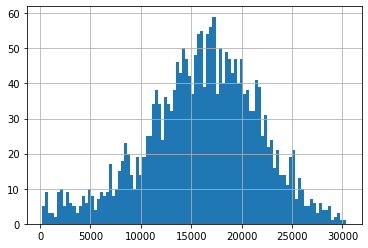

In [49]:
#гистограмма
users_month_pivot_smart['mb_used_sum'].hist(bins=100)

Медиана больше среднего, значит датасет скошен влево.

#### Ultra

{'whiskers': [<matplotlib.lines.Line2D at 0x7fbb7aeb96d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fbb7aeb6ad0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fbb7af2cf90>],
 'medians': [<matplotlib.lines.Line2D at 0x7fbb7aebcc10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fbb7aeb9d10>],
 'means': []}

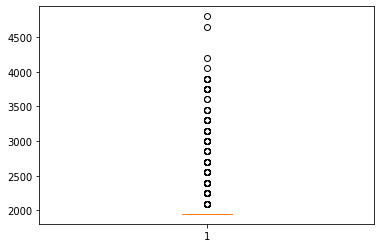

In [50]:
#рассмотрим тариф ultra
plt.boxplot(users_month_pivot_ultra['revenue'])

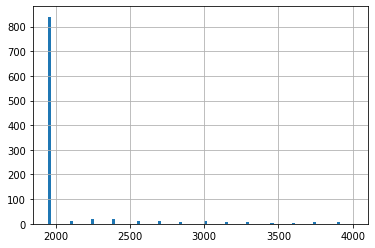

In [51]:
users_month_pivot_ultra['revenue'].hist(bins=100, range=(1950, 4000))

В среднем за месяц люди платят 1800 рублей. Все что больше 2000 рублей можно считать выбросами.

In [52]:
users_month_pivot_ultra = users_month_pivot_ultra.query('revenue <= 2000')

In [53]:
#минуты
print('среднее',users_month_pivot_ultra['calls_sum'].mean())
print('медиана',users_month_pivot_ultra['calls_sum'].median())
print('дисперсия',np.var(users_month_pivot_ultra['calls_sum']))
print('стандартное отклонение',np.sqrt(np.var(users_month_pivot_ultra['calls_sum'])))

среднее 494.19880952380953
медиана 487.0
дисперсия 86907.86166524944
стандартное отклонение 294.8013935944833


In [63]:
#users_month_pivot_ultra.query('calls_sum > 30000').count()

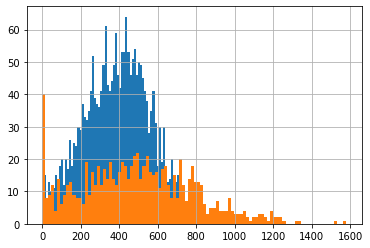

In [55]:
#гистограмма
users_month_pivot_smart['calls_sum'].hist(bins=100)
users_month_pivot_ultra['calls_sum'].hist(bins=100)

Медиана меньшего среднего, значит датасет скошен вправо.

In [56]:
#сообщения
print('среднее',users_month_pivot_ultra['messages_count'].mean())
print('медиана',users_month_pivot_ultra['messages_count'].median())
print('дисперсия',np.var(users_month_pivot_ultra['messages_count']))
print('стандартное отклонение',np.sqrt(np.var(users_month_pivot_ultra['messages_count'])))

среднее 48.86666666666667
медиана 38.5
дисперсия 2125.1607936507935
стандартное отклонение 46.099466305487674


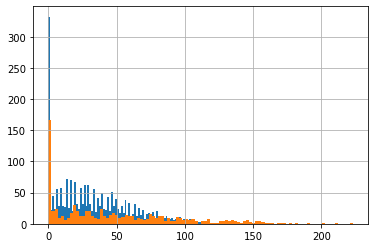

In [57]:
#гистограмма
users_month_pivot_smart['messages_count'].hist(bins=100)
users_month_pivot_ultra['messages_count'].hist(bins=100)

Медиана меньшего среднего, значит датасет скошен вправо.

In [58]:
#объём интернет-трафика 
print('среднее',users_month_pivot_ultra['mb_used_sum'].mean())
print('медиана',users_month_pivot_ultra['mb_used_sum'].median())
print('дисперсия',np.var(users_month_pivot_ultra['mb_used_sum']))
print('стандартное отклонение',np.sqrt(np.var(users_month_pivot_ultra['mb_used_sum'])))

среднее 17049.915476190476
медиана 17433.5
дисперсия 60857110.872617625
стандартное отклонение 7801.096773699043


In [65]:
#users_month_pivot_smart.query('mb_used_sum > 15000').count()

In [61]:
#users_month_pivot_ultra.query('mb_used_sum > 30720').count()

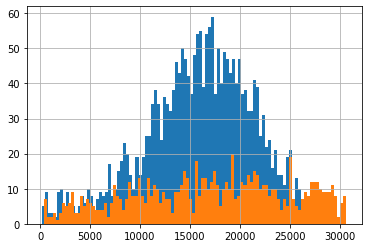

In [60]:
#гистограмма
users_month_pivot_smart['mb_used_sum'].hist(bins=100)
users_month_pivot_ultra['mb_used_sum'].hist(bins=100)

Медиана меньшего среднего, значит датасет скошен вправо.

У тарифа Smart датасеты минут разговора и объёма интернет-трафика скошены влево, а датасет сообщений скошен вправо. Это значит, что абоненты этого тарифа полностью используют минуты разговора и интернет, но не используют сообщения. Плохое использование сообщений может быть связано с тем, что большое количество дюдей сейчас используют мессенджеры и социальные сети. Абоненты Smart берут минут и интернет сверх тарифа.


У тарифа Ultra все датасеты скошены вправо. Абоненты Ultra не используют все ресурсы этого тарифа. Это связано с тем, что тариф дает слишком много ресурсов.

В обоих тарифах абоненты мало позьзуются сообщениями. В тарифе смарт среднее количество сообщений 33, а в тарифе ультра 48. В тарифе смарт не пользовались сообщениями за 2018 год 380 человек, а в ультра - 160.

В тарифе смарт среднее использование минут - 391. А в ультре - 494, при том что всего доступно 3000 минут. В тарифе смарт около 603 переплат в год за минуты, в тарифе ультра нет переплат. 

Средний объём интернет-трафика для тарифа смарт - 16039 (16 гб), для ультра - 17049 (17 гб).В тарифе смарт 1320 переплат в год, в тарифе ультра нет переплат. В тарифе смарт доступно только 15гб интернета, а среднее 16гб. Это говорит о том, что возможности 

Можно сказать, что ниличие только двух таких тарифов не оптимально, нужно их либо изменить, либо ввести третий тариф.

### Шаг 4. Проверьте гипотезы
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

In [108]:
# проверка гипотезы:средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

alpha = 0.05

results = st.ttest_ind(
    users_month_pivot_ultra['revenue'], 
    users_month_pivot_smart['revenue'],
    )

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.93134310456008e-167
Отвергаем нулевую гипотезу


- нулевая гипотеза - средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается
- альтернативная гипотеза - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Отвергаем нулевую гипотезу, значит средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

In [109]:
# проверка гипотезы:
#средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

users_moscow = users_month_pivot.query('city == "Москва"')
users_not_moscow = users_month_pivot.query('city != "Москва"')

alpha = 0.05

results = st.ttest_ind(
    users_moscow['revenue'], 
    users_not_moscow['revenue'],
    )

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.46410213271701706
Не получилось отвергнуть нулевую гипотезу


- нулевая гипотеза - средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
- альтернативная гипотеза - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Не получилось отвергнуть нулевую гипотезу, значит не важно из какого региона пользователь, средняя выручка одинакова.

- какой критерий использовали для проверки гипотез и почему

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применили метод scipy.stats.ttest_ind.

### Шаг 5. Напишите общий вывод

Были проанализированы тарифы  «Смарт» и «Ультра» компании «Мегалайн». 

У тарифа Smart датасеты минут разговора и объёма интернет-трафика скошены влево, а датасет сообщений скошен вправо. Это значит, что абоненты этого тарифа полностью используют минуты разговора и интернет, но не используют сообщения. Плохое использование сообщений может быть связано с тем, что большое количество дюдей сейчас используют мессенджеры и социальные сети. Абоненты Smart берут минут и интернет сверх тарифа.

У тарифа Ultra все датасеты скошены вправо. Абоненты Ultra не используют все ресурсы этого тарифа. Это связано с тем, что тариф дает слишком много ресурсов.

Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается, и не важно из какого региона пользователь, средняя выручка одинакова.